<a href="https://colab.research.google.com/github/kelseyneis/horoscope-mining/blob/main/exploratory_data_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CSCI 5523 Final project
Mohammed Guiga, Kelsey Neis, Sai Sharan Sundar, Josh Spitzer-Resnick

## imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# for reading csv in Colab
# from google.colab import files
# uploaded = files.upload() # if first time uncomment this and manually load in data # use chrome not firefox, not incognito
# import io

# exploratory analysis
import string
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import text 

# Download stopwords
nltk.download('stopwords')
nltk.download('wordnet') # get_lemmas
nltk.download('punkt') # nltk.word_tokenize in get_lemmas

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
# If wordcloud has errors, run these lines and restart the kernel
# !pip install --upgrade pip
# !pip install --upgrade wordcloud

In [3]:
# df = pd.read_csv( io.BytesIO(uploaded['horoscope_saved.csv']) ) # nrows = 100. Use with Google Colab
df = pd.read_csv("../horoscope_saved.csv")
# horoscopes = np.genfromtxt(io.BytesIO(uploaded['horoscope_saved.csv']), delimiter = ',', max_rows = 100)

## exploratory data analysis

### word count visualizations

In [16]:
# lists
signs = ['aries', 'taurus', 'gemini', 'cancer', 'leo', 'virgo', 'libra',
       'scorpio', 'sagittarius', 'capricorn', 'aquarius', 'pisces']
categories = ['general', 'love', 'career', 'wellness', 'birthday']
elements = ['fire', 'earth', 'air', 'water']
fire = ['aries', 'leo', 'sagittarius']
earth = ['taurus', 'virgo', 'capricorn']
air = ['gemini', 'libra', 'aquarius']
water = ['cancer', 'scorpio', 'pisces']
months = ['january', 'february', 'march', 'april', 'may', 'june', 'july', 'august', 'september', 'october', 'november', 'december']

words_to_remove = []
words_to_remove.extend(signs)
words_to_remove.extend(months)

all_horoscopes = df['horoscope']
# all_unique_horoscopes

all_general = df[df['category'] == 'general']['horoscope']
all_love = df[df['category'] == 'love']['horoscope']
all_career = df[df['category'] == 'career']['horoscope']
all_wellness = df[df['category'] == 'wellness']['horoscope']
all_birthday = df[df['category'] == 'birthday']['horoscope'] # wordcloud gives 2 grams for birthday, sometimes for love

In [17]:
horoscopes = all_wellness # change here so code below consistent

In [18]:
# remove punctuation
def remove_punctuation(text):
  no_punct = "".join([c for c in text if c not in string.punctuation])
  return no_punct

# tokenize horoscopes
tokenizer = RegexpTokenizer(r'\w+')

"""
# helper for get_lemmas
def get_wordnet_pos(word): # from https://www.machinelearningplus.com/nlp/lemmatization-examples-python/
    Map POS tag to first character lemmatize() accepts
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)
"""

# Init the Wordnet Lemmatizer # adapted from https://www.machinelearningplus.com/nlp/lemmatization-examples-python/
lemmatizer = WordNetLemmatizer()
def get_lemmas(text): # needs sentence input, not list of words
  # lemmatized_output = ' '.join([lemmatizer.lemmatize(w) for w in text]) # ' '.join([lemmatizer.lemmatize(w) for w in word_list])
  lemmatized_output = [lemmatizer.lemmatize(w) for w in nltk.word_tokenize(text)] # [lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in nltk.word_tokenize(text)]
  """
  lem = []
  for w in text:
    lem.append([wi for wi in map(lemmatizer.lemmatize, w)]) # adapted from https://stackoverflow.com/questions/52860350/how-to-find-the-lemmas-and-frequency-count-of-each-word-in-list-of-sentences-in
  """
  return lemmatized_output # lem
  # [lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in nltk.word_tokenize(sentence)]

# remove stopwords
def remove_stopwords(text):
  words = [w for w in text if w not in stopwords.words('english')]
  return words

# remove sign indicators
def remove_sign_indicators(text):
  doc = [value for value in text if value not in words_to_remove]
  return doc

In [19]:
def preprocess(df):
  df = df.apply(lambda x: remove_punctuation(x))
  # df = df.apply(lambda x: tokenizer.tokenize(x.lower()))
  df = df.apply(lambda x: x.lower())
  
  # df = df.apply(lambda x: lemmatizer.lemmatize(x)) # needs text, not list
  # Make tokens a string again
  # df = [' '.join(map(str, l)) for l in df] # adapted from https://towardsdatascience.com/twitter-topic-modeling-e0e3315b12e2
  df = df.apply(lambda x: get_lemmas(x)) # ''.join(x)) # takes much longer # don't tokenize before lemmatize?
  
  df = df.apply(lambda x: remove_stopwords(x)) # takes longer

  df = df.apply(lambda x: remove_sign_indicators(x))
  return df

In [20]:
tokens = preprocess(horoscopes) # takes ~3min on all_horoscopes

In [46]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [81]:
pos_tags = []
from nltk.tokenize import RegexpTokenizer

tokenizer = RegexpTokenizer(r'\w+')

for horoscope in scorpio:
    tokens = tokenizer.tokenize(horoscope)
    for token in tokens:
        pos_tags.append(token)
    
scorpio_tags = nltk.pos_tag(pos_tags)
scorpio_adj = [t[0] for t in scorpio_tags if t[1] == "JJ"]

/usr/local/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


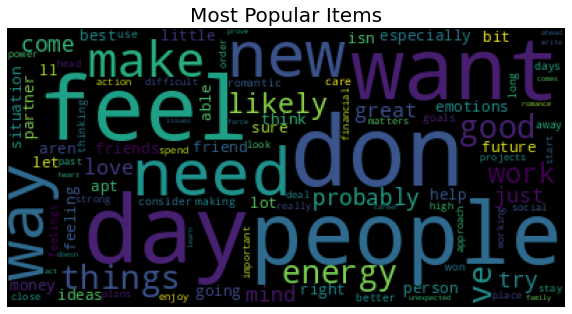

In [80]:
vecs = vectorizer.fit_transform(scorpio)
feature_names = vectorizer.get_feature_names()
dense = vecs.todense()
lst1 = dense.tolist()
feature_adj_bool = np.zeros(len(feature_names), dtype=bool)

cloud_df = pd.DataFrame(lst1, columns=feature_names)
Cloud = WordCloud(background_color="black", max_words=100) \
    .generate_from_frequencies(cloud_df.T.sum(axis=1))

plt.imshow(Cloud)
plt.axis('off')
plt.title('Most Popular Items', fontsize = 20)
plt.show()




In [ ]:
wordclouds_birthday = []
tokens_by_sign_birthday = []
for sign in signs:
    sign_tokens = preprocess(df[(df['sign'] == sign) & (df['category'] == 'birthday')]['horoscope'])
    tokens_by_sign_birthday.append(sign_tokens)
    wordclouds_birthday \
      .append(WordCloud(background_color = 'white', width = 200,  height = 200, max_words = 100, collocation_threshold = 3) \
              .generate(remove_punctuation(str(convert_to_flat_list(sign_tokens)))))

In [ ]:
def show_wordcloud(self, wordcloud, sign):
    self.imshow(wordcloud)
    self.set_axis_off()
    self.set_title(sign)